In [1]:
%cd ../src
%ls

/home/roland/Desktop/Stage_4A/higher-order-diffusion/src
datasets/           data_types.py  __init__.py  __pycache__/  training/  viz/
data_transforms.py  diffusion/     models/      samplers/     utils/


In [2]:
import jax
import jax.numpy as jnp

import jax
import jax.numpy as jnp
import jax.random as random
import flax
from flax import linen as nn
import math
import einops
import time
import optax
import utils.config as config_lib

import datasets as dataset_lib
import utils.logging as loglib

/home/roland/miniconda3/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [3]:
batch_size = 128
dimension = 2
dataset_name = dataset_lib.MOON

# diffusion
T_max = 1.0
# t_0 = 1e-4
num_timesteps = 1000


seed = 42
rng = jax.random.PRNGKey(seed)
num_training_iterations = 10_000
ema_rate = 0.99
num_devices = jax.local_device_count()


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
beta = 1.
M = 1.
gamma = 0.1
Gamma = 2*M**0.5
BETA = lambda t : t*beta
Sigma_xx_0 = 0.
Sigma_vv_0 = gamma*M
Sigma_xx = lambda t : Sigma_xx_0 + jnp.exp(4*BETA(t)/Gamma) - 1 + 4*BETA(t)/Gamma*(Sigma_xx_0 - 1) + 4*(BETA(t)/Gamma)**2*(Sigma_xx_0 - 2) + 16*BETA(t)**2/Gamma**4*Sigma_vv_0
Sigma_xv = lambda t : -BETA(t)*Sigma_xx_0 + 4*BETA(t)/Gamma**2*Sigma_vv_0 - 2*BETA(t)**2/Gamma*(Sigma_xx_0 - 2) - 8*BETA(t)**2/Gamma**3*Sigma_vv_0
Sigma_vv = lambda t : Gamma**2/4*(jnp.exp(4*BETA(t)/Gamma) - 1) + BETA(t)*Gamma + Sigma_vv_0*(1 + 4*(BETA(t)/Gamma)**2 - 4*BETA(t)/Gamma) + BETA(t)**2*(Sigma_xx_0 - 2)

l_HSM = lambda t : jnp.sqrt( Sigma_xx(t)/(Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2) )

L_Cholesky = lambda t : jnp.array([ [jnp.sqrt(Sigma_xx(t)) , jnp.zeros( t.shape ) ] , [ Sigma_xv(t)/jnp.sqrt(Sigma_xx(t)) , jnp.sqrt( (Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2)/Sigma_xx(t) ) ]]).transpose((2,0,1))

# mu for DSM
# def mu(t,x_0,v_0) :
#     return jnp.concatenate([ 2*BETA(t)/Gamma*x_0 + 4*BETA(t)/Gamma**2*v_0 + x_0 , -BETA(t)*x_0 - 2*BETA(t)/Gamma*v_0 + v_0 ], axis = -1 )*jnp.exp(-2*BETA(t)/Gamma)

# mu for HSM (v_0 = 0)
def mu_HSM(t_batch,x_0_batch) :
    batch_size = x_0_batch.shape[0]
    x_0 = x_0_batch
    t = t_batch.flatten()

    # shapes give (2, batch) (batch, dim,1) (batch)  -> (batch, 2, dim, 1) 
    return jnp.array([ 2*BETA(t)/Gamma + 1 , -BETA(t) ]).T.reshape((batch_size,2,1,1))*x_0.reshape((batch_size,1,dimension,1))*jnp.exp(-2*BETA(t)/Gamma).reshape((batch_size,1,1,1))


In [5]:
L_Cholesky(jnp.array([10]))

Array([[[2.202646e+04, 0.000000e+00],
        [8.671389e-03, 2.202646e+04]]], dtype=float32)

In [6]:
# Those are COPY PASTE 

def get_timestep_embedding(timesteps, embedding_dim, max_positions=10000):
    assert len(timesteps.shape) == 1, f"t shape: {len(timesteps.shape)}"
    # and timesteps.dtype == tf.int32
    half_dim = embedding_dim // 2
    # magic number 10000 is from transformers
    emb = math.log(max_positions) / (half_dim - 1)
    # emb = math.log(2.) / (half_dim - 1)
    emb = jnp.exp(jnp.arange(half_dim, dtype=jnp.float32) * -emb)
    # emb = tf.range(num_embeddings, dtype=jnp.float32)[:, None] * emb[None, :]
    # emb = tf.cast(timesteps, dtype=jnp.float32)[:, None] * emb[None, :]
    emb = timesteps[:, None] * emb[None, :]
    emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = jnp.pad(emb, [[0, 0], [0, 1]])
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

class FCBlock(nn.Module):
    hidden_layer: int = 128
    num_layers: int = 3
    activation: nn.Module = nn.relu
    out_dim: int = 32

    @nn.compact
    def __call__(self, x):
        for i in range(self.num_layers):
            x = nn.Dense(self.hidden_layer, name="fc{0}".format(i))(x)
            x = self.activation(x)

        x = nn.Dense(self.out_dim, name="fc_final")(x)
        return x

In [7]:
def real_time(t_index) :
    return( t_index*1.0/num_timesteps)

def real_time_dt(t_index) :
    return( jnp.zeros(t_index.shape) + 1.0/num_timesteps)

class MLPDiffusionModel_CLD(nn.Module):
    t_pos_dim: int = 128
    t_embed_dim: int = 128
    x_embed_dim: int = 128
    v_embed_dim: int = 128
    joint_hidden_dim: int = 128

    @nn.compact
    def __call__(
        self,
        u: jnp.ndarray,
        t: jnp.ndarray,
        # cond: jnp.ndarray = None,
        # train: bool = False,
    ):
        
        batch_size = u.shape[0]
        x = u[...,0,0]
        v = u[...,1,0]
        out_dim = x.shape[-1]

        print('t',t.shape)
        print('x',x.shape)

        t_emb = get_timestep_embedding(t, embedding_dim=self.t_pos_dim)
        print("t_embt_emb",t_emb.shape)
        t_emb = FCBlock(hidden_layer=self.t_embed_dim, out_dim=self.t_embed_dim)(t_emb)
        x_emb = FCBlock(hidden_layer=self.x_embed_dim, out_dim=self.x_embed_dim)(x)
        v_emb = FCBlock(hidden_layer=self.x_embed_dim, out_dim=self.x_embed_dim)(v)
        emb = jnp.concatenate([x_emb, t_emb, v_emb], axis=-1)

        vec = FCBlock(hidden_layer=self.joint_hidden_dim, out_dim=out_dim)(emb)

        vec = v/((l_HSM( real_time(t) )*Sigma_vv( real_time(t) )).reshape((batch_size,1))) + vec


        return vec
    

def get_random_positions(batch, epsilon,t) :
    # batch shape is (batch_size, 2,1)
    # (batch, 2, dim, 1)  + [ (batch, 2,2) @ (batch,dim ,2,1) -> (batch, 2, dim, 1) ]
    
    return mu_HSM(t,batch) + (L_Cholesky(t).reshape((batch_size,1,2,2))@epsilon.reshape((batch_size,dimension,2,1))).transpose((0,2,1,3))

    
    

est ce que l'input du model doit tjr avoir les mêmes shape ? ça expliquerait beaucoup parce que du coup le truc fait un truc du shape du batch même quand j'envoit un seul élément 

In [8]:


model = MLPDiffusionModel_CLD()
# batch = jnp.ones((batch_size, 2,1)) # the last dimension allows easy matrix multiplication on every point
# t = jnp.zeros(batch_size).flatten()
# parameters = model.init(jax.random.PRNGKey(0), batch, t )

# init training state
# --------------------------------------------
data_shape = (2,dimension,1)
dummy_x = jnp.ones((1, *data_shape))
dummy_t = jnp.ones((1,))
rng, init_rng = jax.random.split(rng)


optimizer_config = config_lib.Config(learning_rate=2e-4) # 2e-4 #, b1=0.9, b2=0.999, eps=1e-8)
optimizer = optax.adam(**optimizer_config.as_dict())
model_vars = model.init(rng, dummy_x, dummy_t)
model_state, params = model_vars.pop("params")
opt_state = optimizer.init(params)

@jax.jit
def loss(parameters, key, batch, t) :

    epsilon = random.normal(key, shape = (batch_size, 2*dimension))
    batch = get_random_positions(batch, epsilon, real_time(t))

    model_return = model.apply({'params': parameters}, batch, t)
    # (batch,d) - (batch,d)
    return(jnp.sum( (epsilon[:,dimension:2*dimension] - model_return )**2) )

t (1,)
x (1, 2)
t_embt_emb (1, 128)


In [9]:
# Set up
# --------------------------------------------
# --------------------------------------------

# data
# --------------------------------------------
train_ds, eval_ds = dataset_lib.get_dataset(
    dataset_name,
    train_batch_size=batch_size,
    eval_batch_size=batch_size,
    num_jit_steps=None,
    image_size=None,
    random_flip=None,
    data_category=None,
    uniform_dequantization=False,
    num_two_dim_samples=10_000,
)
train_iter = iter(train_ds)

# set up data transform
transform_fn = lambda x: x

In [10]:
# training loop
# --------------------------------------------
start_time = time.time()
losses = []
for it in range(num_training_iterations):
    rng, train_rng, time_rng, init_rng = jax.random.split(rng, 4)
    batch = jax.tree_map(lambda x: x._numpy(), next(train_iter))
    x = batch["x"]
    z = transform_fn(x).reshape((batch_size,2,1))

    t = random.randint(key = time_rng, shape = (batch_size,) , minval= 1, maxval = num_timesteps)
    loss_value, grads = jax.value_and_grad(loss)(params, train_rng, z, t)
    # grads = jax.grad(loss)(params, train_rng, z, t)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # metrics
    if it % 500 == 0:
        losses.append(loss_value)
        runtime = time.time() - start_time
        # train_state = flax.jax_utils.unreplicate(pstate)
        
        print_metrics = {"iteration": it, "loss": loss_value, "runtime": runtime}
        loglib.print_metrics(print_metrics)

t (128,)
x (128, 2)
t_embt_emb (128, 128)
iteration: 0 - loss: 155.080856 - runtime: 1.796844
iteration: 500 - loss: 63.450169 - runtime: 13.883602
iteration: 1000 - loss: 70.513092 - runtime: 26.465969
iteration: 1500 - loss: 61.076096 - runtime: 38.895651
iteration: 2000 - loss: 84.753540 - runtime: 51.401557
iteration: 2500 - loss: 88.235168 - runtime: 65.501423
iteration: 3000 - loss: 75.912392 - runtime: 78.531522
iteration: 3500 - loss: 80.845352 - runtime: 91.123184
iteration: 4000 - loss: 61.361568 - runtime: 103.753968
iteration: 4500 - loss: 63.920559 - runtime: 116.949963
iteration: 5000 - loss: 54.814156 - runtime: 130.305853
iteration: 5500 - loss: 76.550140 - runtime: 142.855665
iteration: 6000 - loss: 86.130905 - runtime: 155.280860
iteration: 6500 - loss: 69.304916 - runtime: 167.906874
iteration: 7000 - loss: 68.324150 - runtime: 181.608364
iteration: 7500 - loss: 39.052578 - runtime: 194.207784
iteration: 8000 - loss: 88.914391 - runtime: 206.847747
iteration: 8500 - 

In [11]:
def score(u,t_indexes) :
    print("lalalalalal", t_indexes.shape)
    return( - l_HSM(real_time(t_indexes))*model.apply( {'params': params} , u ,t) )



In [12]:
# def Euler_probability_flow_step(u , f , G , score_func , t_index ) :
#     # convention is : T corresponds to the time of the prior distrib p_T and t=0 corresponds to data distrib p_0
#     t = real_time(t_index)
#     return( -f(u, t) + 0.5*G(u,t)@G(u,t).T@score_func(u,t) )

# def Euler_probability_flow_generator(x_T , f , G , score_func , num_timesteps= num_timesteps) :

#     def f(u,t_index) :
#         return (Euler_probability_flow_step(u , f , G , score_func , t_index ),None) # must return a second argument, can be None
#     f_jitted = jax.jit(f)

#     x_0,_ = jax.lax.scan( f_jitted , init = x_T, xs = jnp.array(range(num_timesteps,0,-1)) ) # remember that the score is defined from t_index =1 not from t_index = 0
#     return x_0


In [13]:
def vectorize_arrays(arrays) :
    result = jnp.array([])
    shapes = []
    for i in range(len(arrays)) :
        shapes.append(arrays[i].shape)
        result = jnp.concatenate( (result , arrays[i].flatten()), axis = 0 ) 
    return(result,shapes)

def unvectorize_arrays(vector,shapes) :
    lengths = [ jnp.prod(jnp.array(shapes[i])) for i in range(len(shapes))]
    cum_sum_lengths = jnp.cumsum(jnp.array([0] + lengths))
    arrays = [ vector[cum_sum_lengths[i] : cum_sum_lengths[i+1]].reshape[shapes[i]] for i in range(len(cum_sum_lengths)-1) ]
    return(arrays)
    


In [14]:
def Euler_probability_flow_step(u , score_func , t_index_gauss_noise ) :
    # convention is : T corresponds to the time of the prior distrib p_T and t=0 corresponds to data distrib p_0
    # here u is shape (2,1)
    x = u[:,0].squeeze()
    v = u[:,1].squeeze()

    # t_index = t_index_gauss_noise["t_index"]
    # gauss_noise = t_index_gauss_noise["gauss_noise"]
    
    # (t_index,gauss_noise) = unvectorize_arrays(vector = t_index_gauss_noise ,shapes = [ (1,1) , (batch_size,2,1) ])
    t_index = t_index_gauss_noise[0].reshape((1,1))
    print('ici ???', t_index.shape)
    gauss_noise = t_index_gauss_noise[1:].reshape((batch_size, dimension))

    t = real_time(t_index)
    print("la ???", t.shape)
    dt = real_time_dt(t_index)

    print("v",v.shape)
    print("score_func(u,t",score_func(u,t).shape)
    print("beta",beta)

    # score function : (batch,dim)
    # v : (batch,dim,1)
    print("tttt_indexx", t_index.shape)
    C1 = jnp.array( [ [-v/M*beta*dt] , [ (x*beta + Gamma*(score_func(u,t_index) + v/M))*beta*dt  + jnp.sqrt(2*Gamma*beta*dt)*gauss_noise ] ] ).transpose((2,0,3,1 ))  # REVOIR il manque le bruit !!!!!

    print(C1)
    print("C1",C1.shape)
    print("dt",dt.shape)
    values = C1
    
    # 
    return( C1, values )


# def Euler_probability_flow_step(u , score_func , t_index ) :
#     # convention is : T corresponds to the time of the prior distrib p_T and t=0 corresponds to data distrib p_0
#     t = real_time(t_index)
#     dt = real_time_dt(t_index)
#     return(  )

# Euler_probability_flow_step = jax.vmap(Euler_probability_flow_step_one_axis, in_axes= (0,None,None), out_axes=0, axis_name=None, axis_size=None, spmd_axis_name=None)
Euler_probability_flow_step_batch = jax.vmap(Euler_probability_flow_step, in_axes= (0,None,None), out_axes=0, axis_name=None, axis_size=None, spmd_axis_name=None)

def Euler_probability_flow_generator( u_T , score_func , num_timesteps= num_timesteps ) :

    def f(u,t_index_gauss_noise) :
        return Euler_probability_flow_step(u , score_func ,  t_index_gauss_noise ) # must return a second argument, can be None
    f_jitted = f # jax.jit(f) REVOIR 

    rng = jax.random.PRNGKey(seed+1)
    gauss_noise = jax.random.normal(key = rng, shape=(num_timesteps, batch_size, dimension,1))
    t_index =  jnp.broadcast_to(array = jnp.array(range(num_timesteps,0,-1)).reshape((1,-1,1)) , shape = (batch_size,num_timesteps,1) )
    xs = [ jnp.concatenate( [t_index[i].flatten(),gauss_noise[i].flatten() ], axis = 0) for i in range(num_timesteps) ]
    xs = jnp.array(xs)
    
    x_0, values = jax.lax.scan( f_jitted , init = u_T, xs = xs ) # remember that the score is defined from t_index =1 not from t_index = 0

    print("values", values)
    return x_0

In [15]:
rng = jax.random.PRNGKey(seed+2)
u_T =  jax.random.normal(key = rng, shape =(128,2,2,1))

x = Euler_probability_flow_generator(u_T = u_T , score_func = score , num_timesteps= num_timesteps)

AttributeError: 'ArrayImpl' object has no attribute 'broadcast_to'

In [ ]:
# article : flow matching doesn't use stochastic  

import matplotlib.pyplot as plt

In [ ]:
print(x.shape)

(128, 2, 2, 1)


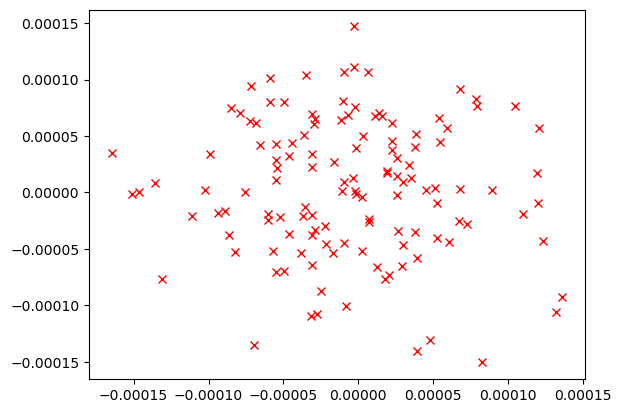

In [ ]:
plot_x = x[:,0,:,0]
plt.plot(plot_x[ :,0], plot_x[:,1], 'rx')

In [ ]:
import numpy as np

In [ ]:
grid_w = 1
res = 50
x,y = jnp.meshgrid(np.linspace(-grid_w,grid_w,res),np.linspace(-grid_w,grid_w,res))
x.shape, y.shape
flat_x = einops.rearrange(x, 'a b -> (a b)')
flat_y = einops.rearrange(y, 'a b -> (a b)')
network_input = jnp.stack([flat_x, flat_y], -1)

t_0 = 0.01
score_fn = score

for t in jnp.arange(t_0, T_max, T_max/10):

    t = jnp.ones(network_input.shape[0])*t
    score = score_fn(x=network_input, t=t)
    dx, dy = jnp.split(score, 2, axis=-1)
    plt.quiver(flat_x, flat_y,dx,dy)
    plt.show()

TypeError: score() got an unexpected keyword argument 'x'